In [1]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import (Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU,
                                     Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from IPython import display

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

dcgan_path = Path('data', 'dcgan')
img_path = dcgan_path / 'synthetic_images'
if not img_path.exists():
    img_path.mkdir(parents=True)

Using GPU


In [3]:
# Sample Image Saver
def generate_and_save_images(model, epoch, test_input):
    # Training set to false so that every layer runs in inference mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5, 5.2))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    fig.suptitle(f'Epoch {epoch:03d}', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.93)
    fig.savefig(img_path / f'epoch_{epoch:03d}.png', dpi=300)
    plt.show()

In [4]:
# use only train images
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

In [5]:
# Extract image dimensions
n_images = train_images.shape[0] # get dimensionality
h = w = 28

train_images = (train_images.reshape(n_images, h, w, 1).astype('float32')) # Reshape to 4D input format
train_images = (train_images - 127.5) / 127.5 # Normalize the images in between -1 and 1

# Create tf.data.Dataset
BUFFER_SIZE = n_images
BATCH_SIZE = 256
train_set = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))
train_set

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [6]:
# Create DCGAN Architecture
def build_generator():
    return Sequential([Dense(7 * 7 * 256, use_bias=False, input_shape=(100,), name='IN'),
                       BatchNormalization(name='BN1'),
                       LeakyReLU(name='RELU1'),
                       Reshape((7, 7, 256), name='SHAPE1'),
                       Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False,
                                       name='CONV1'),
                       BatchNormalization(name='BN2'),
                       LeakyReLU(name='RELU2'),
                       Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                       name='CONV2'),
                       BatchNormalization(name='BN3'),
                       LeakyReLU(name='RELU3'),
                       Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                       activation='tanh', name='CONV3')], name='Generator')

generator = build_generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IN (Dense)                  (None, 12544)             1254400   
                                                                 
 BN1 (BatchNormalization)    (None, 12544)             50176     
                                                                 
 RELU1 (LeakyReLU)           (None, 12544)             0         
                                                                 
 SHAPE1 (Reshape)            (None, 7, 7, 256)         0         
                                                                 
 CONV1 (Conv2DTranspose)     (None, 7, 7, 128)         819200    
                                                                 
 BN2 (BatchNormalization)    (None, 7, 7, 128)         512       
                                                                 
 RELU2 (LeakyReLU)           (None, 7, 7, 128)         0 

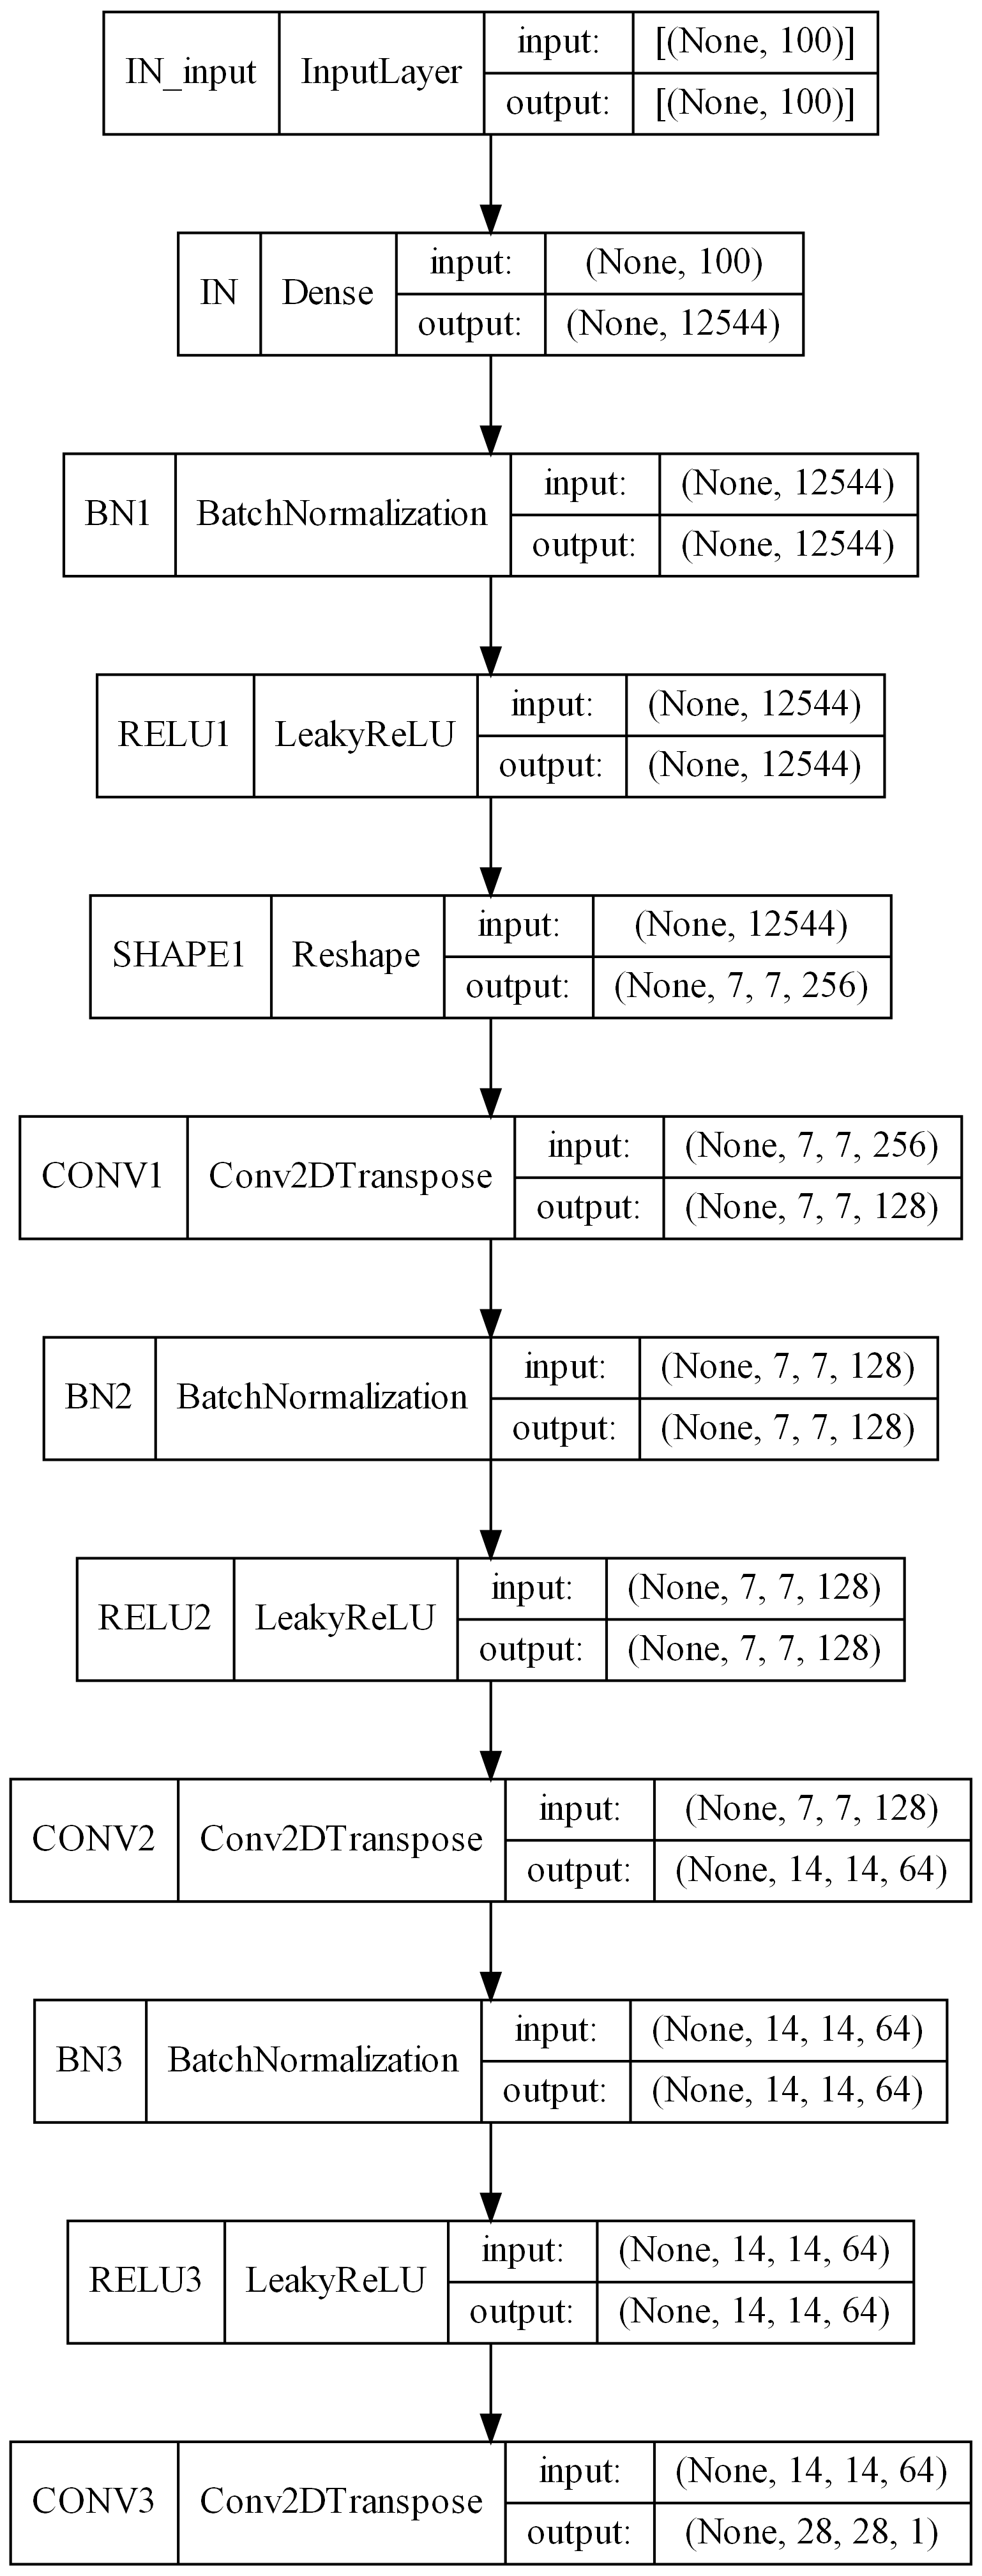

In [7]:
plot_model(generator, show_shapes=True, dpi=300, to_file=(dcgan_path / 'generator.png').as_posix())

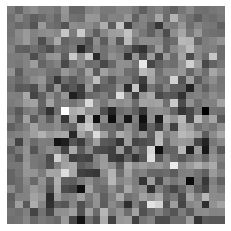

In [8]:
# Visualize initial image quality
noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)

plt.imshow(generated_img[0, :, :, 0], cmap='gray')
plt.axis('off');

In [9]:
# Build Discriminator
def build_discriminator():
    return Sequential([Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1],
                              name='CONV1'),
                       LeakyReLU(name='RELU1'),
                       Dropout(0.3, name='DO1'),
                       Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='CONV2'),
                       LeakyReLU(name='RELU2'),
                       Dropout(0.3, name='DO2'),
                       Flatten(name='FLAT'),
                       Dense(1, name='OUT')], name='Discriminator')

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 14, 14, 64)        1664      
                                                                 
 RELU1 (LeakyReLU)           (None, 14, 14, 64)        0         
                                                                 
 DO1 (Dropout)               (None, 14, 14, 64)        0         
                                                                 
 CONV2 (Conv2D)              (None, 7, 7, 128)         204928    
                                                                 
 RELU2 (LeakyReLU)           (None, 7, 7, 128)         0         
                                                                 
 DO2 (Dropout)               (None, 7, 7, 128)         0         
                                                                 
 FLAT (Flatten)              (None, 6272)            

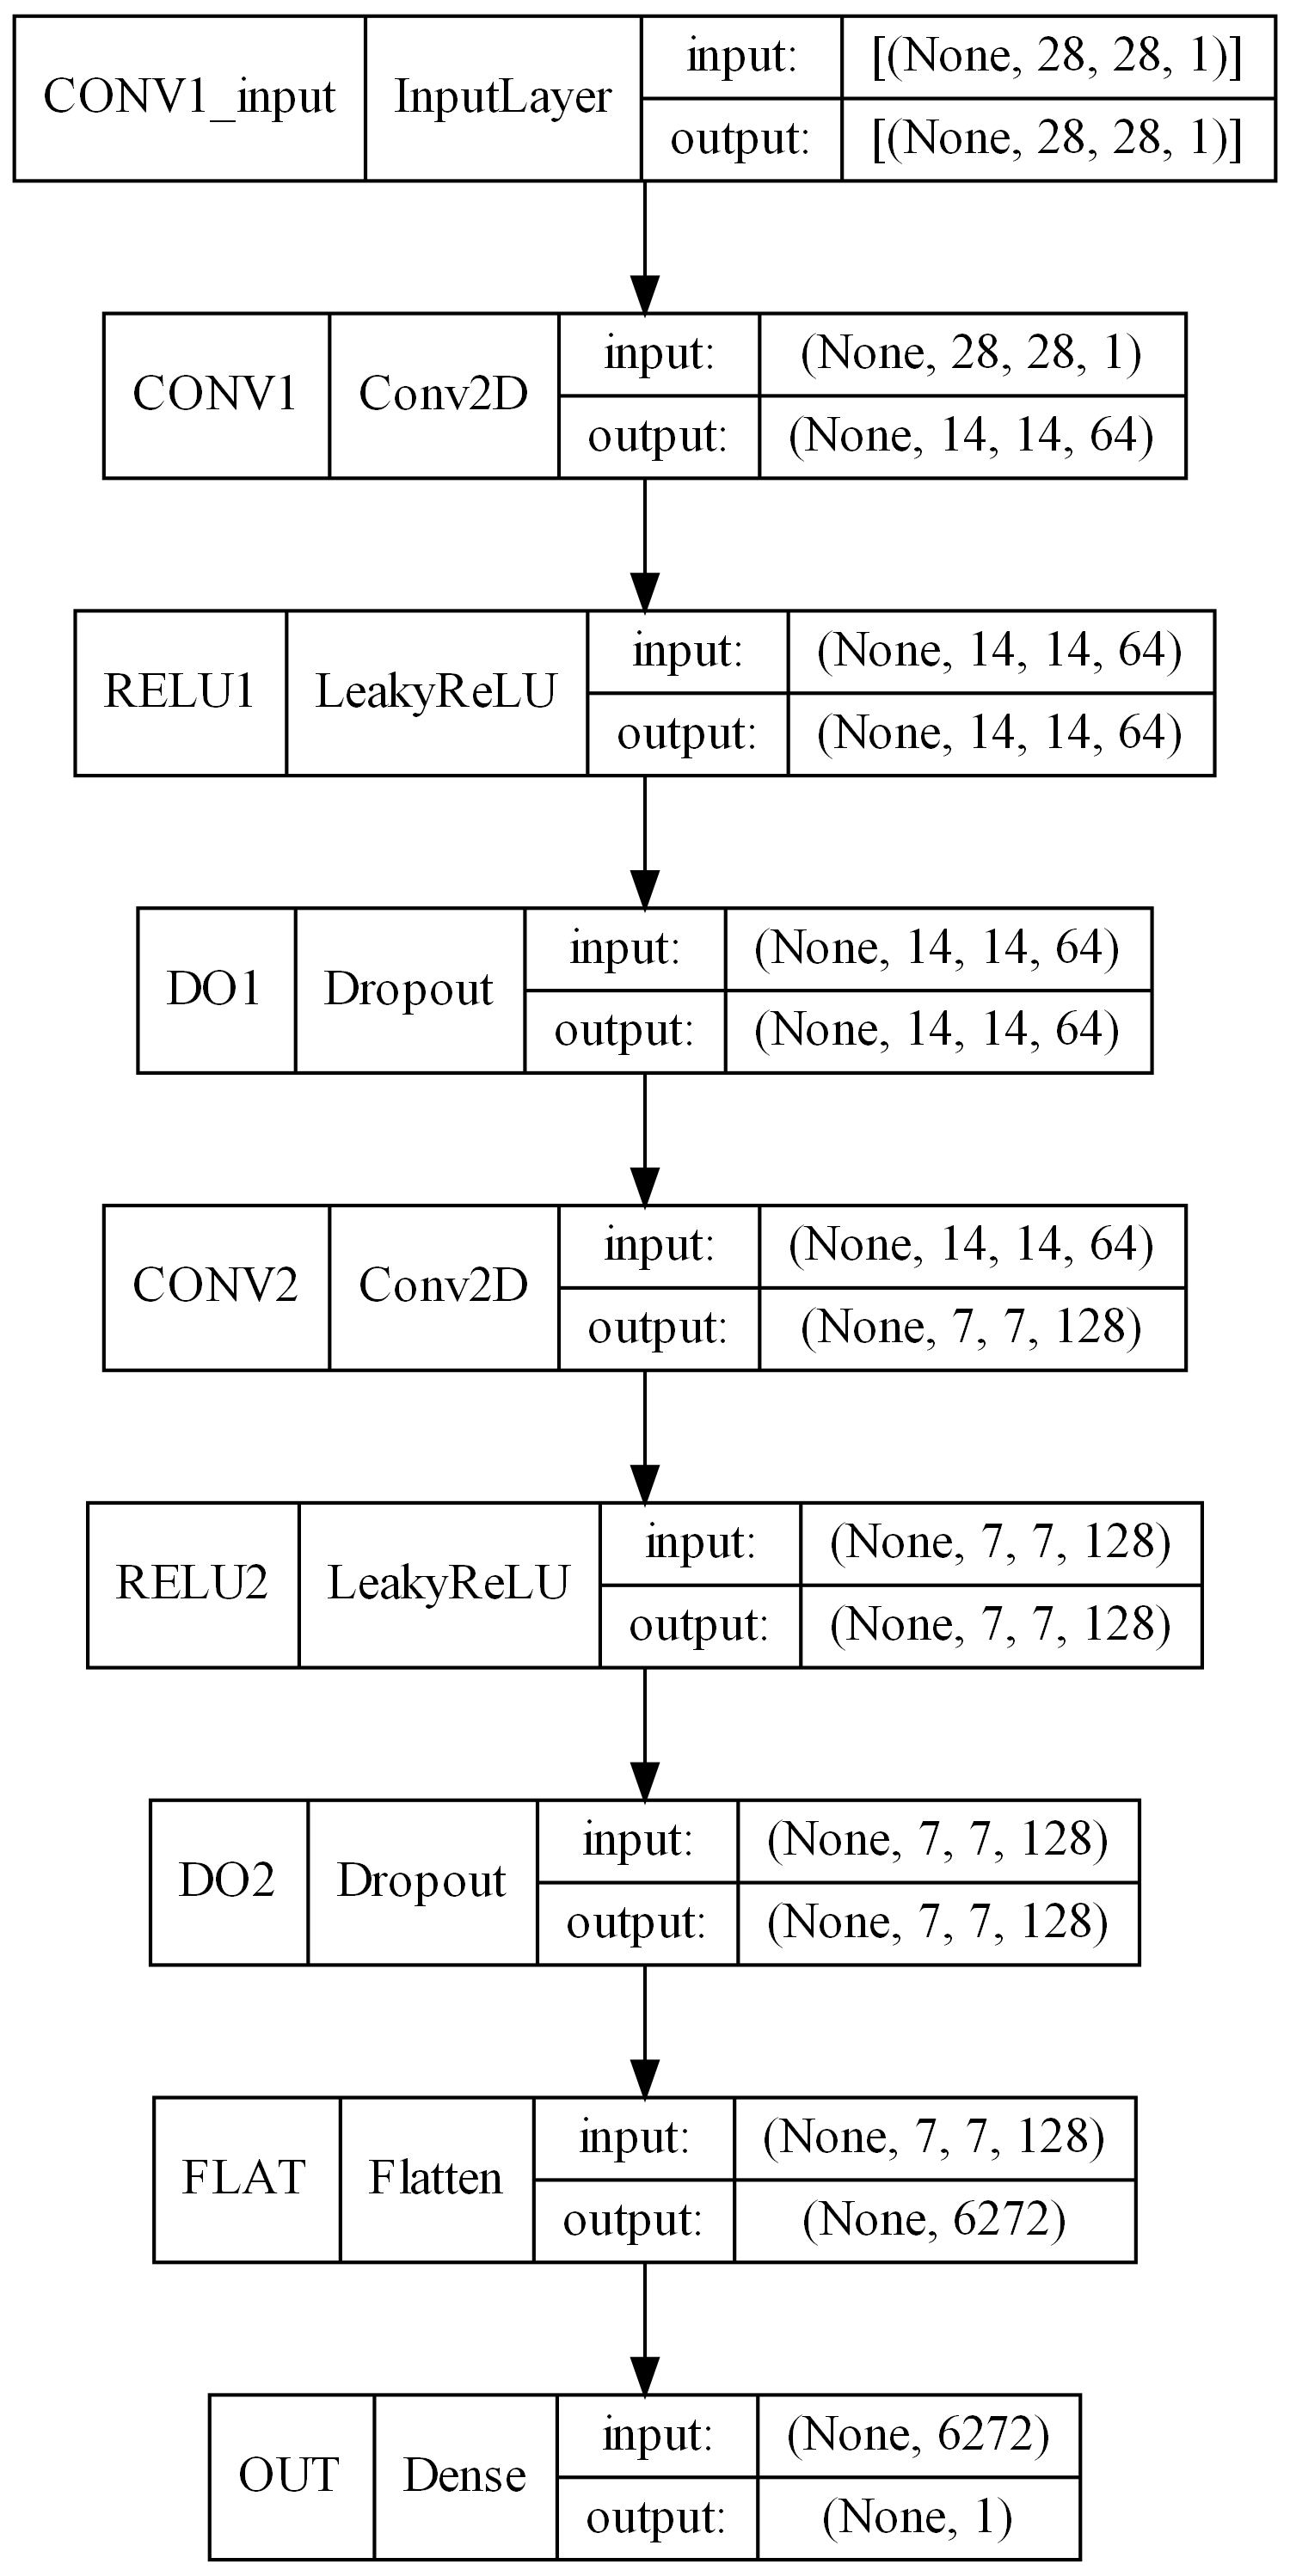

In [10]:
plot_model(discriminator, show_shapes=True, dpi=300, to_file=(dcgan_path / 'discriminator.png').as_posix())

In [11]:
# Show discriminator decision output
discriminator(generated_img).numpy()

array([[0.00166225]], dtype=float32)

In [12]:
cross_entropy = BinaryCrossentropy(from_logits=True) # Adversarial Training

# Generator Loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator Loss
def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return true_loss + fake_loss

# Optimizers
gen_optimizer = Adam(1e-4)
dis_optimizer = Adam(1e-4)

# Checkpoints
checkpoints_dir = dcgan_path / 'training_chpk'
checkpoint_prefix = checkpoints_dir / 'ckpt'
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer, dis_optimizer=dis_optimizer,
                                 generator=generator, discriminator=discriminator)

In [13]:
# Training Parameters
EPOCHS = 100
noise_dim = 100
# for gif generation
num_ex_to_gen = 16
seed = tf.random.normal([num_ex_to_gen, noise_dim])

In [14]:
# Training Step
@tf.function
def train_step(images):
    # generate the random input for the generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # get the generator output
        generated_img = generator(noise, training=True)

        # collect discriminator decisions regarding real and fake input
        true_output = discriminator(images, training=True)
        fake_output = discriminator(generated_img, training=True)

        # compute the loss for each model
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)

    # compute the gradients for each loss with respect to the model variables
    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # apply the gradient to complete the backpropagation step
    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

# Training Loop
def train(dataset, epochs, save_every=10):
    for epoch in tqdm(range(epochs)):
        start = time()

        for img_batch in dataset:
            train_step(img_batch)

        # produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 10 EPOCHS
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Generator after final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

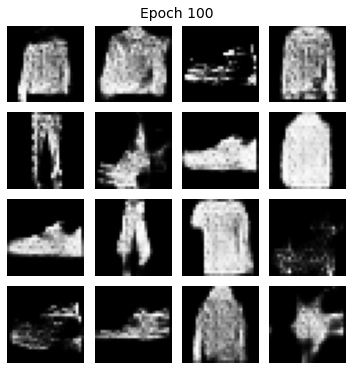

In [15]:
train(train_set, EPOCHS)

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir)); # Restore last checkpoint

In [17]:
out_file = dcgan_path / 'fashion_mnist.gif' # Generate animated GIF

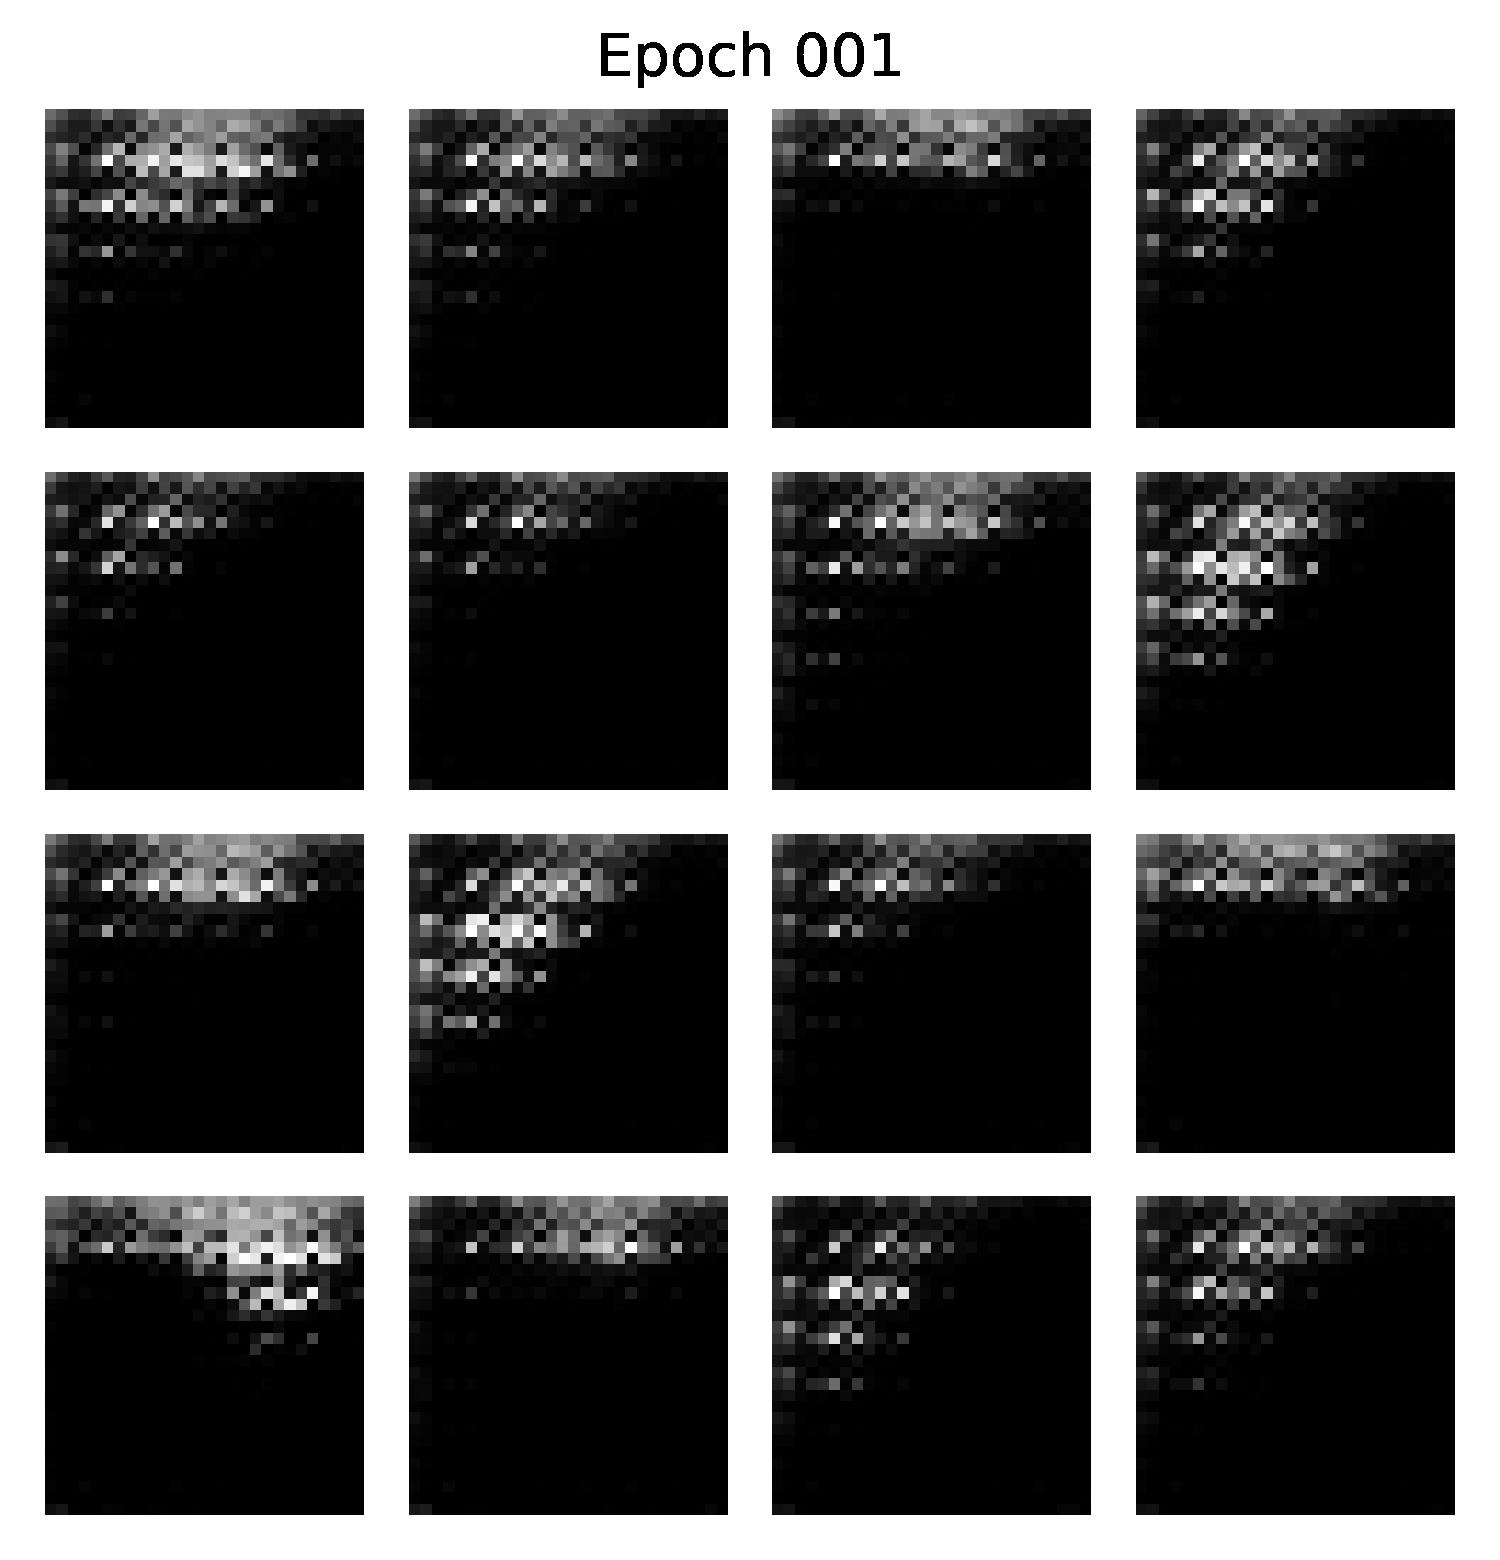

In [18]:
with imageio.get_writer(out_file, mode='I') as writer:
    filenames = sorted(list(img_path.glob('*.png')))

    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display.Image(filename=out_file)